Всем привет!

Почти без лишних слов -- сразу к делу.

Загрузите данные к себе на GDrive. Сейчас мы к нему подключимся

In [1]:
# Отдельная благодарность Савелию Прохорову за предоставление и проверку бейзлайна в Colab

from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/MyDrive/dataset_CV_bootcamp/
%ls

Mounted at /gdrive
/gdrive/MyDrive/dataset_CV_bootcamp
datasets/


Все, что нам нужно теперь сделать, если (в нашем случае, когда) для нас были правильно собраны данные -- так это подготовить для себя папку с валидацией. По факту, нужно перенести некоторые картинки из папки `/train` в аналогичною ей по субдиректориям папку `/validation`

**Было так:**
```
|-datasets
|---train
|-----images
|-------<images>
|-----labels
|-------<images labels in txt>
```

**Должно стать так:**
```
|-datasets
|---train
|-----images
|-------<images for train>
|-----labels
|-------<train images labels in txt>
|---validation
|-----images
|-------<images for validation>
|-----labels
|-------<validation images labels in txt>
```

In [ ]:
%mkdir datasets/validation
%mkdir datasets/validation/images
%mkdir datasets/validation/labels
%ls

data.yaml  output_train.csv  train/  validation/


Случайным образом перенесем ~10% картинок и их лейблов в новую директорию

Дальше мы дополним конфигурационный файл, нужный для непосредственно обучения модели детекции

In [ ]:
%cat data.yaml

# Paths to training and validation image directories
train: /path/to/train/here

# Number of classes
nc: 3

# Class names
names: ['plane', 'car', 'ship']

In [ ]:
%%writefile data.yaml
# Paths to training and validation image directories
train: train/images
val: validation/images

# Number of classes
nc: 3

# Class names
names: ['plane', 'car', 'ship']

Overwriting data.yaml


In [ ]:
%cat data.yaml

# Paths to training and validation image directories
train: train/images
val: validation/images

# Number of classes
nc: 3

# Class names
names: ['plane', 'car', 'ship']


Установим нужную библиотеку

In [ ]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 922.6/922.6 kB 36.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 64.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 35.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 34.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

Обучим модель

In [ ]:
import os
import json
from PIL import Image

# Пути к папкам с изображениями и аннотациями (txt-файлы)
images_dir = 'datasets/train/images'
labels_dir = 'datasets/train/labels'
output_json = 'datasets/train/annotations.json'

# Список изображений (расширения можно дополнять)
image_files = [f for f in os.listdir(images_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

# Определяем категории (пример: 0 - корабль, 1 - самолёт, 2 - машина)
categories = [
    {"id": 0, "name": "ship", "supercategory": "none"},
    {"id": 1, "name": "airplane", "supercategory": "none"},
    {"id": 2, "name": "car", "supercategory": "none"}
]

images = []
annotations = []
ann_id = 1  # уникальный идентификатор для каждой аннотации

for img_id, file_name in enumerate(image_files):
    img_path = os.path.join(images_dir, file_name)
    # Открываем изображение для получения размеров
    with Image.open(img_path) as img:
        width, height = img.size

    # Формируем информацию об изображении
    image_info = {
        "id": img_id,
        "width": width,
        "height": height,
        "file_name": file_name
    }
    images.append(image_info)

    # Путь к соответствующему txt-файлу с аннотациями (предполагается, что имя совпадает)
    label_file = os.path.join(labels_dir, os.path.splitext(file_name)[0] + '.txt')
    if os.path.exists(label_file):
        with open(label_file, 'r') as f:
            lines = f.readlines()
        for line in lines:
            line = line.strip()
            if not line:
                continue
            # Разбираем строку формата: <class> <x_center> <y_center> <width> <height>
            parts = line.split()
            if len(parts) != 5:
                continue
            class_id, x_center, y_center, w_norm, h_norm = map(float, parts)
            # Преобразуем нормализованные значения в абсолютные координаты
            x_center_abs = x_center * width
            y_center_abs = y_center * height
            w_abs = w_norm * width
            h_abs = h_norm * height
            # Переводим в формат COCO: [x_min, y_min, width, height]
            x_min = x_center_abs - w_abs / 2
            y_min = y_center_abs - h_abs / 2

            annotation = {
                "id": ann_id,
                "image_id": img_id,
                "category_id": int(class_id),
                "bbox": [x_min, y_min, w_abs, h_abs],
                "area": w_abs * h_abs,
                "iscrowd": 0
            }
            annotations.append(annotation)
            ann_id += 1

# Собираем итоговую структуру в формате COCO
coco_format = {
    "images": images,
    "annotations": annotations,
    "categories": categories
}

# Сохраняем в JSON-файл
with open(output_json, 'w') as f:
    json.dump(coco_format, f, indent=4)

print(f"COCO-аннотации сохранены в {output_json}")


COCO-аннотации сохранены в datasets/train/annotations.json


In [ ]:
import os
import json
from PIL import Image

test_images_dir = 'datasets/test/images'
output_json = 'datasets/test/annotations.json'

# Получаем список изображений
image_files = [f for f in os.listdir(test_images_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

images = []
for img_id, file_name in enumerate(image_files):
    img_path = os.path.join(test_images_dir, file_name)
    with Image.open(img_path) as img:
        width, height = img.size
    image_info = {
        "id": img_id,
        "width": width,
        "height": height,
        "file_name": file_name
    }
    images.append(image_info)

# Формируем dummy COCO-файл для тестового набора
dummy_coco = {
    "images": images,
    "annotations": [],
    "categories": []  # можно оставить пустым, либо скопировать категории из обучающего набора, если нужно
}

with open(output_json, 'w') as f:
    json.dump(dummy_coco, f, indent=4)

print(f"Dummy COCO file for test saved to {output_json}")


Dummy COCO file for test saved to datasets/test/annotations.json


In [3]:
!pip install -U openmim
!mim install mmengine
!mim install "mmcv>=2.0.0"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.5/259.5 kB 6.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.0/57.0 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.1/50.1 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.7/89.7 kB 8.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 449.6/449.6 kB 28.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.5/311.5 kB 26.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.4/239.4 kB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 506.5/506.5 kB 37.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.1/77.1 kB 7.5 MB/s eta 0:0

^C
^C


In [1]:
!git clone https://github.com/open-mmlab/mmdetection.git

Cloning into 'mmdetection'...
remote: Enumerating objects: 38023, done.
remote: Total 38023 (delta 0), reused 0 (delta 0), pack-reused 38023 (from 1)
Receiving objects: 100% (38023/38023), 63.25 MiB | 11.99 MiB/s, done.
Resolving deltas: 100% (26223/26223), done.


In [12]:

!mim install "mmcv==2.1.0"

Looking in links: https://download.openmmlab.com/mmcv/dist/cu121/torch2.1.0/index.html
  Using cached https://download.openmmlab.com/mmcv/dist/cu121/torch2.1.0/mmcv-2.1.0-cp311-cp311-manylinux1_x86_64.whl (94.1 MB)
  Using cached addict-2.4.0-py3-none-any.whl.metadata (1.0 kB)
  Using cached mmengine-0.10.7-py3-none-any.whl.metadata (20 kB)
  Using cached yapf-0.43.0-py3-none-any.whl.metadata (46 kB)
Using cached mmengine-0.10.7-py3-none-any.whl (452 kB)
Using cached addict-2.4.0-py3-none-any.whl (3.8 kB)
Using cached yapf-0.43.0-py3-none-any.whl (256 kB)
  Using cached mmdet-2.25.0.tar.gz (793 kB)
  Preparing metadata (setup.py) ... done
  Using cached mmdet-2.25.0.tar.gz (793 kB)
  Preparing metadata (setup.py) ... done
  Using cached mmdet-2.25.0.tar.gz (793 kB)
  Preparing metadata (setup.py) ... done
  Using cached mmdet-2.25.0.tar.gz (793 kB)
  Preparing metadata (setup.py) ... done
  Using cached mmdet-2.25.0.tar.gz (793 kB)
  Preparing metadata (setup.py) ... done
  Using cache

In [6]:
pip install torch==2.1.0 torchvision==0.16.0 torchaudio==2.1.0 --index-url https://download.pytorch.org/whl/cu121

Looking in indexes: https://download.pytorch.org/whl/cu121
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 GB 558.4 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 64.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 65.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.2/89.2 MB 10.7 MB/s eta 0:00:00
  Attempting uninstall: triton
    Found existing installation: triton 3.1.0
    Uninstalling triton-3.1.0:
      Successfully uninstalled triton-3.1.0
  Attempting uninstall: torch
    Found existing installation: torch 2.5.1+cu124
    Uninstalling torch-2.5.1+cu124:
      Successfully uninstalled torch-2.5.1+cu124
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.20.1+cu124
    Uninstalling torchvision-0.20.1+cu124:
      Successfully uninstalled torchvision-0.20.1+cu124
  Attempting uninstall: torchaudio
    Found existing installation: torchaudio 2.5.1+cu124
    Uninstalling tor

In [10]:
!mim download mmdet --config rtmdet_tiny_8xb32-300e_coco --dest .

Traceback (most recent call last):
  File "/usr/local/bin/mim", line 8, in <module>
    sys.exit(cli())
             ^^^^^
  File "/usr/local/lib/python3.11/dist-packages/click/core.py", line 1161, in __call__
    return self.main(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/click/core.py", line 1082, in main
    rv = self.invoke(ctx)
         ^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/click/core.py", line 1697, in invoke
    return _process_result(sub_ctx.command.invoke(sub_ctx))
                           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/click/core.py", line 1443, in invoke
    return ctx.invoke(self.callback, **ctx.params)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/click/core.py", line 788, in invoke
    return __callback(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/pyt

In [9]:
!python demo/image_demo.py demo/demo.jpg rtmdet_tiny_8xb32-300e_coco.py --weights rtmdet_tiny_8xb32-300e_coco_20220902_112414-78e30dcc.pth --device cpu

Traceback (most recent call last):
  File "/content/mmdetection/demo/image_demo.py", line 5, in <module>
    from mmdet.apis import (async_inference_detector, inference_detector,
  File "/content/mmdetection/mmdet/__init__.py", line 2, in <module>
    import mmcv
ModuleNotFoundError: No module named 'mmcv'


In [7]:
%cd mmdetection
!git checkout v2.25.0
!pip install -e .

[Errno 2] No such file or directory: 'mmdetection'
/content/mmdetection
HEAD is now at ca11860f Bump version to v2.25.0
Obtaining file:///content/mmdetection
  Preparing metadata (setup.py) ... done
  Attempting uninstall: mmdet
    Found existing installation: mmdet 2.25.0
    Uninstalling mmdet-2.25.0:
      Successfully uninstalled mmdet-2.25.0
  Running setup.py develop for mmdet


In [15]:
!pip install torch==2.1.0 torchvision==0.16.0 torchaudio==2.1.0 --index-url https://download.pytorch.org/whl/cu121


Looking in indexes: https://download.pytorch.org/whl/cu121


In [16]:
!pip install -U openmim


In [17]:
!mim install mmengine

Looking in links: https://download.openmmlab.com/mmcv/dist/cu121/torch2.1.0/index.html
  Using cached mmengine-0.10.7-py3-none-any.whl.metadata (20 kB)
  Using cached addict-2.4.0-py3-none-any.whl.metadata (1.0 kB)
  Using cached yapf-0.43.0-py3-none-any.whl.metadata (46 kB)
Using cached mmengine-0.10.7-py3-none-any.whl (452 kB)
Using cached addict-2.4.0-py3-none-any.whl (3.8 kB)
Using cached yapf-0.43.0-py3-none-any.whl (256 kB)
  Using cached mmdet-2.25.0.tar.gz (793 kB)
  Preparing metadata (setup.py) ... done
  Using cached mmdet-2.25.0.tar.gz (793 kB)
  Preparing metadata (setup.py) ... done
  Using cached mmdet-2.25.0.tar.gz (793 kB)
  Preparing metadata (setup.py) ... done
  Using cached mmdet-2.25.0.tar.gz (793 kB)
  Preparing metadata (setup.py) ... done
  Using cached mmdet-2.25.0.tar.gz (793 kB)
  Preparing metadata (setup.py) ... done
  Using cached mmdet-2.25.0.tar.gz (793 kB)
  Preparing metadata (setup.py) ... done
  Using cached mmdet-2.25.0.tar.gz (793 kB)
  Preparing 

In [19]:
!pip install mmengine==0.10.7


In [24]:
!pip install "mmcv==1.6.0" -f https://download.openmmlab.com/mmcv/dist/cu121/torch2.1.0/index.html

Looking in links: https://download.openmmlab.com/mmcv/dist/cu121/torch2.1.0/index.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 554.9/554.9 kB 18.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for mmcv: filename=mmcv-1.6.0-py2.py3-none-any.whl size=848007 sha256=e95833457b4e36fd51f9ae818da9351077c1a7858998bc58a036b56a43116daa
  Stored in directory: /root/.cache/pip/wheels/12/9f/86/9d197da28599f4ab6d3f30384499fa2fa9e277adb2da01f0c5
Successfully built mmcv
  Attempting uninstall: mmcv
    Found existing installation: mmcv 2.1.0
    Uninstalling mmcv-2.1.0:
      Successfully uninstalled mmcv-2.1.0


In [ ]:
%cd mmdetection
!git checkout v2.25.0
!pip install -e .


In [2]:
#from mmcv.configs import Config
from mmengine.config import Config
from mmdet.datasets import build_dataset
from mmmengine.models import build_detector
from mmengine.apis import train_detector

print('Фух, импортровалось нормально')
# Загружаем конфигурационный файл (укажи путь к выбранному конфигу)
cfg = Config.fromfile('configs/deformable_detr/deformable_detr_r50_16x2_50e_coco.py')

# Указываем пути к тренировочным данным
cfg.data.train.img_prefix = 'datasets/train/images/'
cfg.data.train.ann_file = 'datasets/train/annotations.json'

# Если тестовые данные используются для инференса
cfg.data.test.img_prefix = 'datasets/test/images/'
cfg.data.test.ann_file = 'datasets/test/annotations.json'

# Обновляем число классов (например, 3: корабли, самолёты, машины)
cfg.model.bbox_head.num_classes = 3

# Используем предобученные веса (если они есть)
cfg.load_from = 'checkpoints/deformable_detr_r50_16x2_50e_coco_20210817.pth'

# Настраиваем workflow, если валидации нет
cfg.workflow = [('train', 1)]

# Добавляем логирование с Tensorboard (если требуется)
cfg.log_config = dict(
    interval=50,
    hooks=[
        dict(type='TextLoggerHook'),
        dict(type='TensorboardLoggerHook')
    ])

# Пример изменения пайплайна для аугментации (замени или дополни существующий)
cfg.data.train.pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations', with_bbox=True),
    dict(
        type='Resize',
        img_scale=[(1333, 600), (1333, 800)],
        multiscale_mode='range',
        keep_ratio=True
    ),
    dict(type='RandomFlip', flip_ratio=0.5),
    dict(type='PhotoMetricDistortion'),
    dict(
        type='Normalize',
        mean=[123.675, 116.28, 103.53],
        std=[58.395, 57.12, 57.375],
        to_rgb=True
    ),
    dict(type='Pad', size_divisor=32),
    dict(type='DefaultFormatBundle'),
    dict(type='Collect', keys=['img', 'gt_bboxes', 'gt_labels'])
]

# Построение датасета и модели
datasets = [build_dataset(cfg.data.train)]
model = build_detector(cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
model.CLASSES = datasets[0].CLASSES

# Запуск обучения (без распределённого режима, если используется один GPU)
train_detector(model, datasets, cfg, distributed=False, validate=False)


ModuleNotFoundError: No module named 'mmcv._ext'

Посмотрим на детекцию на одном примере

In [ ]:
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import cv2

img_name = os.listdir("datasets/")[10]
print(img_name)
full_img_path = "datasets/validation/images/" + img_name

img = cv2.imread(full_img_path)
plt.imshow(img)

FileNotFoundError: [Errno 2] No such file or directory: 'datasets/validation/images'


image 1/1 /gdrive/MyDrive/CVBootcamp_Kaggle_Detection/datasets/validation/images/29bd364e-5b5f-4d5e-894a-e1f64a16f17a.jpg: 640x640 1 ship, 79.4ms
Speed: 4.2ms preprocess, 79.4ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)
tensor([[0.1372, 0.0980, 0.0326, 0.0474]], device='cuda:0')
tensor([2.], device='cuda:0')
None


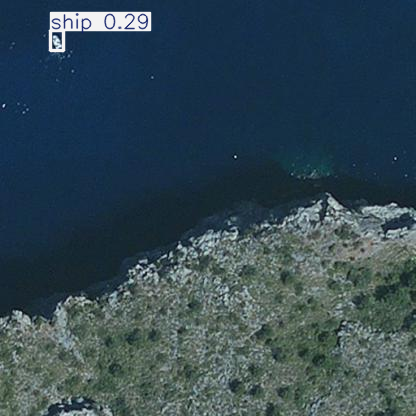

In [ ]:
model = YOLO("runs/detect/train3/weights/best.pt")  # Поменяйте путь к вашему чекпоинту, смотрите его выше в логе обучения
results = model(full_img_path)

for result in results:
    boxes = result.boxes  # Boxes object for bounding box outputs
    print(boxes.xywhn)  # Boxes in requested format
    print(boxes.cls)  # Classes of boxes
    result.show()  # display to screen
    result.save(filename="result.jpg")  # save to disk

Неплохо. Пора делать submission

In [ ]:
import pandas as pd
import glob

test_images_path_prefix = "datasets/test/images/"
test_images_names = glob.glob(test_images_path_prefix + "*.jpg")

df = pd.DataFrame(
    columns=["image", "class_id", "center_x", "center_y", "width", "height"]
)

paths = [img_name for img_name in test_images_names]

batches = []
for _ in range(len(test_images_names)):
    batches.append(paths[_])


all_res = []
for b in batches:
    results_batch = model(b)
    all_res.append(results_batch)

for j, results in enumerate(all_res):
    for i in range(len(results)):
        boxes = results[i].boxes
        xywhn = boxes.xywhn.cpu()
        cls = boxes.cls.cpu()
        img_name = test_images_names[j]
        for ind in range(len(boxes)):
            submission_info = [img_name.split("/")[-1]]+[int(cls[ind])] + xywhn[ind].tolist()
            df.loc[len(df)] = submission_info

        if len(boxes) == 0:
            submission_info = [img_name.split("/")[-1], None, None, None, None, None]
            df.loc[len(df)] = submission_info

df

In [ ]:
df.to_csv("submission.csv", index=False)

In [ ]:
# В силу специфики соревнования нужно перепаковать CSV в специфический формат
# Он плохо читаем человеком, поэтому на всякий случай конвертацию приводим отдельно
# Сделаем ровно это

import csv
import json
from collections import defaultdict

input_csv = 'submission.csv'
output_csv = 'converted.csv'


data = defaultdict(list)


with open(input_csv, newline='') as csvfile:
    reader = csv.DictReader(csvfile, delimiter=',')
    for row in reader:
        image = row['image']
        bbox = str(row['class_id']) + ' '+ str(row['center_x']) + ' ' + str(row['center_y']) + ' ' + str(row['width']) + ' ' + str(row['height'])

        data[image].append(bbox)

with open(output_csv, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['id', 'label'])
    for image, bboxes in data.items():
        result_json = json.dumps(bboxes, separators=("\t", "\n"))
        writer.writerow([image, result_json])